# Time Series Breakdown of Retail Sales
This notebook is a **self-contained** time-series analysis of synthetic retail sales (Walmart-like). It includes trend/seasonality analysis and simple forecasting (exponential smoothing). Run top-to-bottom.

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams.update({"figure.figsize": (10,5), "axes.grid": True})
print('Libraries ready')

Libraries ready


In [2]:
# Generate synthetic monthly sales data from 2015-01 to 2022-12
date_range = pd.date_range(start='2015-01-01', end='2022-12-31', freq='MS')
n_months = len(date_range)
regions = ['East', 'West', 'Central', 'South']
categories = ['Electronics', 'Clothing', 'Grocery', 'Furniture']

rows = []
np.random.seed(42)
for dt in date_range:
    month = dt.month
    # base seasonality pattern by month (higher in Nov-Dec for retail)
    seasonal_factor = 1.0 + 0.2 * np.sin(2 * np.pi * (month-1) / 12) + 0.25 * (1 if month in [11,12] else 0)
    for r in regions:
        region_multiplier = {'East':1.1, 'West':1.0, 'Central':0.9, 'South':1.05}[r]
        for c in categories:
            cat_base = {'Electronics': 120000, 'Clothing': 80000, 'Grocery': 150000, 'Furniture': 60000}[c]
            # trend component: steady growth over years
            years_from_start = (dt.year - 2015) + (dt.month-1)/12.0
            trend = 1.02 ** years_from_start  # ~2% monthly compounding over years (annualized ~27% - intentionally high to create visible trend)
            # random noise
            noise = np.random.normal(loc=1.0, scale=0.08)
            sales = cat_base * seasonal_factor * region_multiplier * trend * noise
            rows.append({'Date': dt, 'Region': r, 'Category': c, 'Sales': float(round(sales,2))})

df = pd.DataFrame(rows)
df.to_csv('synthetic_retail_monthly.csv', index=False)
print('Generated', len(df), 'rows. Sample:') 
df.head()

Generated 1536 rows. Sample:


,Date,Region,Category,Sales
0,2015-01-01,East,Electronics,137245.30
1,2015-01-01,East,Clothing,87026.62
2,2015-01-01,East,Grocery,173549.49
3,2015-01-01,East,Furniture,74041.60
4,2015-01-01,West,Electronics,117752.13


        Date       Sales YearMonth
0 2015-01-01  1657316.78   2015-01
1 2015-02-01  1782781.15   2015-02
2 2015-03-01  1902629.94   2015-03
3 2015-04-01  1978892.91   2015-04
4 2015-05-01  1969872.82   2015-05


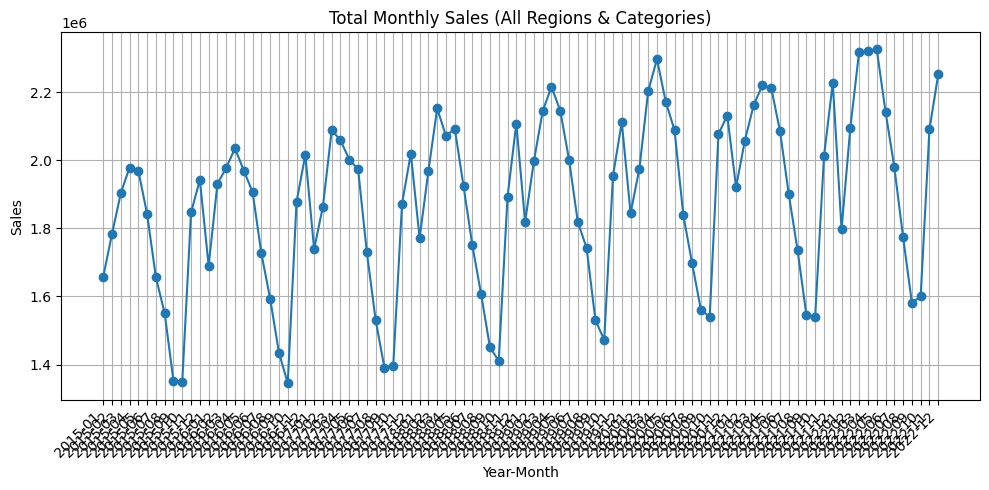

In [3]:
# Aggregate total monthly sales (all regions/categories)
monthly_total = df.groupby('Date', as_index=False)['Sales'].sum()
monthly_total['YearMonth'] = monthly_total['Date'].dt.to_period('M').astype(str)

# Display a small table
print(monthly_total.head())

# Plot overall sales trend
plt.figure()
plt.plot(monthly_total['YearMonth'], monthly_total['Sales'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.title('Total Monthly Sales (All Regions & Categories)')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

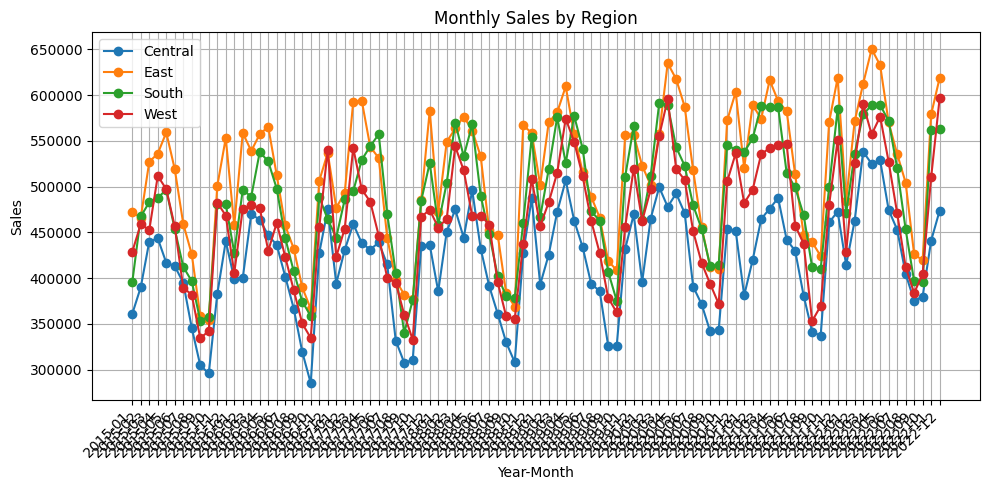

In [4]:
# Sales by region (time series)
region_ts = df.groupby(['Date','Region'], as_index=False)['Sales'].sum()
# Pivot for plotting
region_pivot = region_ts.pivot(index='Date', columns='Region', values='Sales').fillna(0)

plt.figure()
for col in region_pivot.columns:
    plt.plot(region_pivot.index.to_period('M').astype(str), region_pivot[col], marker='o', label=col)
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Monthly Sales by Region')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

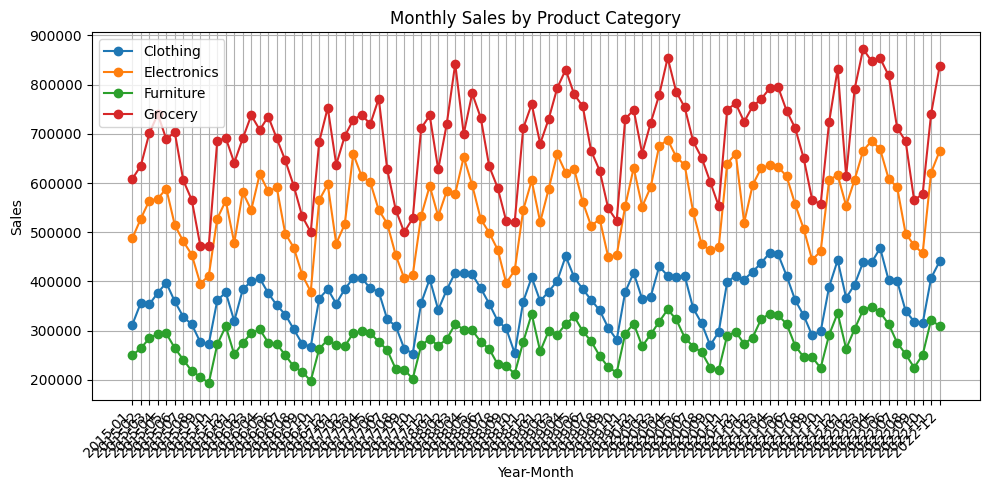

In [5]:
# Sales by product category
cat_ts = df.groupby(['Date','Category'], as_index=False)['Sales'].sum()
cat_pivot = cat_ts.pivot(index='Date', columns='Category', values='Sales').fillna(0)

plt.figure()
for col in cat_pivot.columns:
    plt.plot(cat_pivot.index.to_period('M').astype(str), cat_pivot[col], marker='o', label=col)
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Monthly Sales by Product Category')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

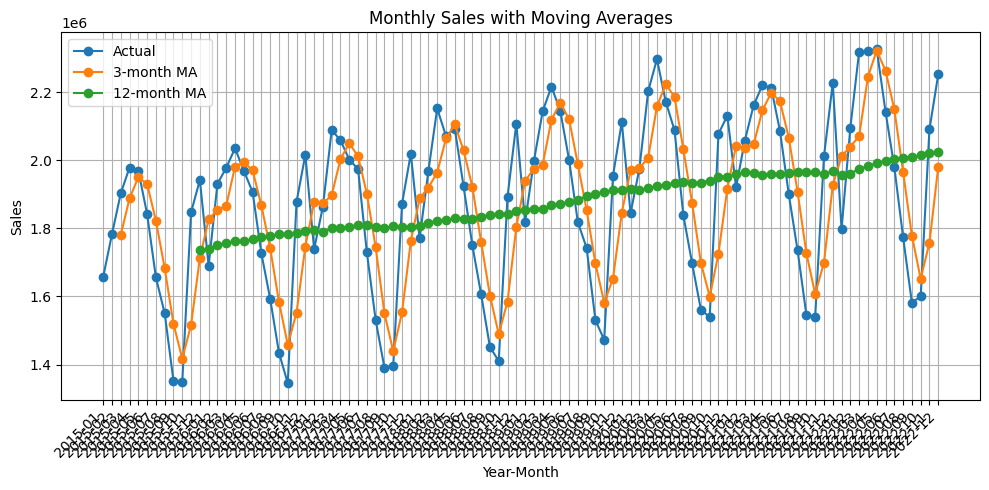

In [6]:
# Rolling averages (3-month and 12-month) on total monthly sales
monthly_total = monthly_total.sort_values('Date').reset_index(drop=True)
monthly_total['MA_3'] = monthly_total['Sales'].rolling(window=3, center=False).mean()
monthly_total['MA_12'] = monthly_total['Sales'].rolling(window=12, center=False).mean()

plt.figure()
plt.plot(monthly_total['YearMonth'], monthly_total['Sales'], marker='o', label='Actual')
plt.plot(monthly_total['YearMonth'], monthly_total['MA_3'], marker='o', label='3-month MA')
plt.plot(monthly_total['YearMonth'], monthly_total['MA_12'], marker='o', label='12-month MA')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.title('Monthly Sales with Moving Averages')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

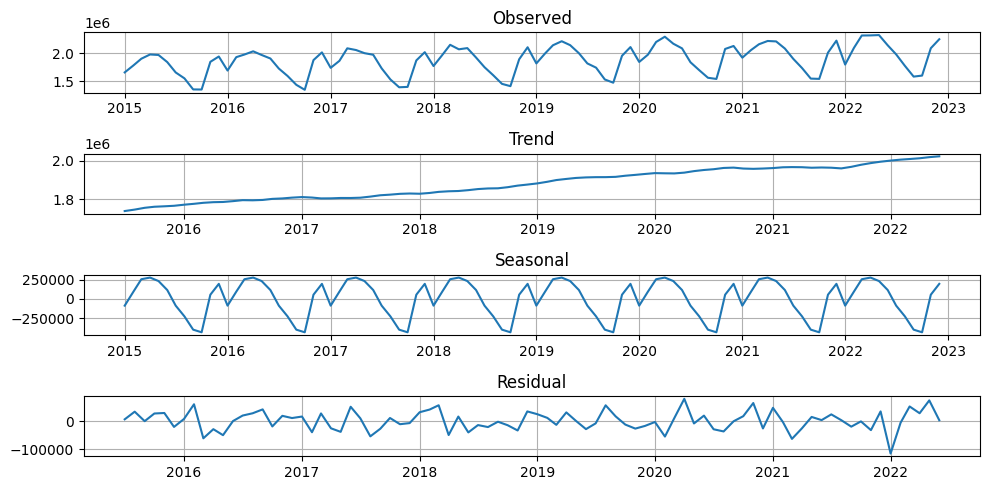

In [7]:
# Seasonal decomposition (additive) - try statsmodels, else fallback to manual monthly indices
from pandas import Series
decomposition_result = None
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    monthly_series = monthly_total.set_index(pd.to_datetime(monthly_total['Date']))['Sales']
    decomposition = seasonal_decompose(monthly_series, model='additive', period=12)
    # Plot components
    plt.figure()
    plt.subplot(411)
    plt.plot(decomposition.observed); plt.title('Observed')
    plt.subplot(412)
    plt.plot(decomposition.trend); plt.title('Trend')
    plt.subplot(413)
    plt.plot(decomposition.seasonal); plt.title('Seasonal')
    plt.subplot(414)
    plt.plot(decomposition.resid); plt.title('Residual')
    plt.tight_layout()
    plt.show()
    decomposition_result = 'statsmodels'
except Exception as e:
    print('statsmodels not available or decomposition failed — using fallback seasonal index. Error:', e)
    # Fallback: compute monthly seasonal index (average per month / overall mean)
    monthly_total['Month'] = pd.to_datetime(monthly_total['Date']).dt.month
    month_index = monthly_total.groupby('Month')['Sales'].mean() / monthly_total['Sales'].mean()
    print('Monthly seasonal index (fallback):\\n', month_index)

C:\Users\Zohaib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Zohaib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


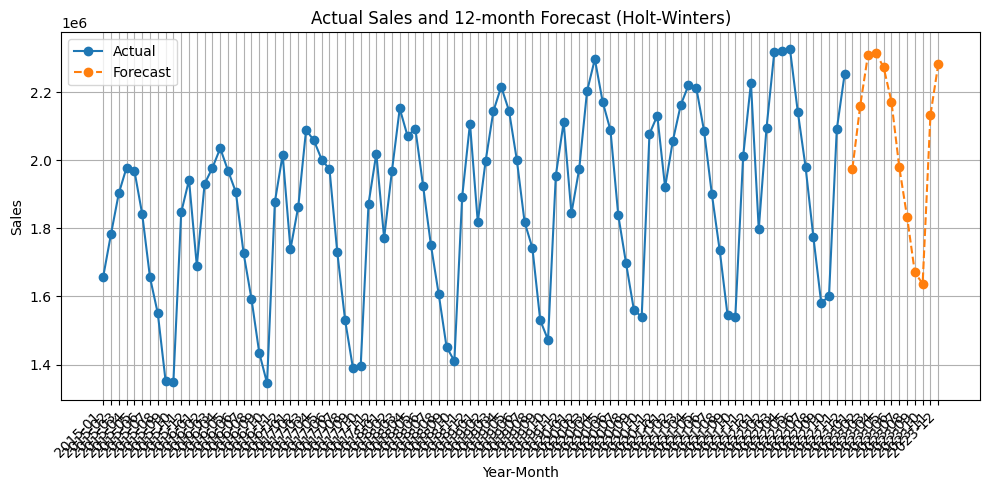

Forecast method used: statsmodels_hw


,Date,Forecast
0,2023-01-01,1.975317e+06
1,2023-02-01,2.160348e+06
2,2023-03-01,2.310489e+06
3,2023-04-01,2.315378e+06
4,2023-05-01,2.273610e+06


In [8]:
# Simple exponential smoothing forecast for next 12 months
forecast_steps = 12
last_date = monthly_total['Date'].max()
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=forecast_steps, freq='MS')

# Try statsmodels' ExponentialSmoothing first
forecast = None
try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    series = monthly_total.set_index(pd.to_datetime(monthly_total['Date']))['Sales']
    model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=12)
    fit = model.fit(optimized=True)
    pred = fit.forecast(forecast_steps)
    forecast = pd.DataFrame({'Date': pred.index, 'Forecast': pred.values})
    # Plot actual + forecast
    plt.figure()
    plt.plot(monthly_total['Date'].dt.to_period('M').astype(str), monthly_total['Sales'], marker='o', label='Actual')
    combined_x = list(monthly_total['Date'].dt.to_period('M').astype(str)) + list(pred.index.to_period('M').astype(str))
    combined_y = list(monthly_total['Sales']) + list(pred.values)
    # Plot forecast portion separately
    plt.plot(pred.index.to_period('M').astype(str), pred.values, marker='o', linestyle='--', label='Forecast')
    plt.xticks(rotation=45, ha='right')
    plt.title('Actual Sales and 12-month Forecast (Holt-Winters)')
    plt.xlabel('Year-Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()
    forecast_method = 'statsmodels_hw'
except Exception as e:
    print('statsmodels Holt-Winters not available — using pandas EWM fallback. Error:', e)
    # Fallback: use exponential weighted mean of historical series and project forward as flat value or slowly growing
    series = monthly_total.sort_values('Date')['Sales']
    alpha = 0.2
    ewma_last = series.ewm(alpha=alpha).mean().iloc[-1]
    # simple projection: continue ewma value with slight trend equal to last observed monthly growth mean
    monthly_growth = series.pct_change().dropna().mean()
    forecast_values = [ewma_last * ((1+monthly_growth)**(i+1)) for i in range(forecast_steps)]
    forecast = pd.DataFrame({'Date': future_dates, 'Forecast': forecast_values})
    plt.figure()
    plt.plot(monthly_total['Date'].dt.to_period('M').astype(str), monthly_total['Sales'], marker='o', label='Actual')
    plt.plot(forecast['Date'].dt.to_period('M').astype(str), forecast['Forecast'], marker='o', linestyle='--', label='Forecast (EWM fallback)')
    plt.xticks(rotation=45, ha='right')
    plt.title('Actual Sales and 12-month Forecast (EWM fallback)')
    plt.xlabel('Year-Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()
    forecast_method = 'ewm_fallback'

print('Forecast method used:', forecast_method)
forecast.head()

In [9]:
# Save notebook artifact (already created by this script as well)
print('Notebook saved alongside this environment as TimeSeries_Retail_Sales_Analysis.ipynb')


Notebook saved alongside this environment as TimeSeries_Retail_Sales_Analysis.ipynb
